In [1]:
import matplotlib.pyplot as plt
from utilities.cbm_models import *
import numpy as np
import pandas as pd
import optuna

import argparse
import os
import wandb
import re
import clip

from PIL import Image
import cv2

from utils.dcbm import *


2025-05-22 08:39:42.841879: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-22 08:39:43.533495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# ----------------- Fix -----------------
embed_path = "../Embeddings/"
dataset = "cub"
concept_path = "../Concepts/"
class_labels_path = "/ceph/pknab/pknab/03_CLIP/SegCBM/Datasets/CUB_200_2011/classes.txt"
segment_path = "../Segments/Seg_embs/"
selected_image_concepts = "../Embeddings/subsets"
raw_path_dataset = "../Datasets/CUB_200_2011/images/"


# ----------------- Hyperparameters -----------------

model_name = "CLIP-ViT-B16"  # "CLIP-ViT-L14", "CLIP-RN50"
model_name = "CLIP-ViT-L14"

segmentation_technique = "SAM2"  # GDINO, SAM, SAM2, DETR, MaskRCNN
raw_path = "../Segments/CUB_200_2011_SAM2/crops"  # adapt to path of raw segments
concept_name = None #"partimagenet"  # Define for GDINE [awa, sun, sun-lowthresh, cub...]

device = "cuda:1"

clusters = 2048
cluster_method = "kmeans"  # "hierarchical", "kmeans"
centroid_method = "median"  # "mean", "median"

concept_per_class = None  # How many images for each class 5,10,20,50, None

one_hot = False
epochs = 200
lambda_1 = 1e-4
lr = 1e-4
batch_size = 32

crop = False  # True without background

use_wandb = True
project = "SegCBM_ALL"  # Define your own project name within wandb

In [3]:
cbm = CBM(
    embed_path, dataset, model_name, class_labels_path, device=device
)  # Initialize CBM

cbm.load_concepts(
    segment_path,
    segmentation_technique,
    concept_name,
    selected_image_concepts,
    concept_per_class,
    crop=crop,
)  # Load concepts with predefined segmentation technique and hyperparameters

if clusters is not None:  # if clustering is needed
    cbm.cluster_image_concepts(cluster_method, clusters, pca = False)
else:
    cbm.clustered_concepts = cbm.image_segments

cbm.centroid_concepts(
    centroid_method
)  # Calculate centroids of the concepts with given method


Path ../Embeddings/images_travelling_birds_test_CLIP-ViT-L14.torch does not exist
Train data loaded from ../Embeddings/images_CUB_train_CLIP-ViT-L14.torch
Validation data loaded from ../Embeddings/images_CUB_val_CLIP-ViT-L14.torch
Test data loaded from ../Embeddings/images_CUB_test_CLIP-ViT-L14.torch
Concept path:  ../Segments/Seg_embs/segcrop_CUB_200_2011_SAM2_CLIP-ViT-L14.torch


/ceph/pknab/pknab/03_CLIP/SegCBM/CBM/utilities/cbm.py:792: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  concepts_dict = torch.load(concept_path, map_location=device)


Concepts loaded from  ../Segments/Seg_embs/segcrop_CUB_200_2011_SAM2_CLIP-ViT-L14.torch
PCA:  False
Number of image embeddings:  38416
Number of clusters:  2048
Clustering method:  kmeans
Clustered images saved


In [4]:
cbm.concept_intervention(
    "gull",
    0.23
)

cbm.preprocess_data(
    type_="standard", label_type=one_hot
)  # preprocess data for training

Removed 67 concepts from the clustered concepts.


Processing Batches:   0%|          | 0/6 [00:00<?, ?it/s]/ceph/pknab/pknab/03_CLIP/SegCBM/CBM/utilities/cbm.py:1026: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, device=device, dtype=torch.float32)
Processing Batches: 100%|██████████| 6/6 [00:00<00:00, 99.62it/s]

Scaler fitted


Data transformed


Processing Batches:   0%|          | 0/1 [00:00<?, ?it/s]/ceph/pknab/pknab/03_CLIP/SegCBM/CBM/utilities/cbm.py:1026: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, device=device, dtype=torch.float32)
Processing Batches:   0%|          | 0/6 [00:00<?, ?it/s]/ceph/pknab/pknab/03_CLIP/SegCBM/CBM/utilities/cbm.py:1026: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, device=device, dtype=torch.float32)
Processing Batches: 100%|██████████| 6/6 [00:00<00:00, 1220.52it/s]

(5394, 1981) (5794, 1981) (600, 1981) (5394, 200) (5794, 200) (600, 200)


In [5]:
cbm_model = cbm.train(  # train the model
    num_epochs=epochs,
    lambda_1=lambda_1,
    lr=lr,
    batch_size=batch_size,
    device=device,
    project=project,
    to_print=False,
    early_stopping_patience=None,
    one_hot=one_hot,
    use_wandb=use_wandb,
)

learning rate:  0.0001
lambda_1:  0.0001


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: knab. Use `wandb login --relogin` to force relogin


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


background,▁
batch_size,▁
ce_loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
clusters,▁
l1_loss,▅▇████▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
lambda_1,▁
lr,▁
one_hot,▁
test_accuracy,▁▆▇▇▇███████████████████████████████████
test_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▅▆▇▇▇▇▇▇▇██████████████████████████████


In [6]:
model = CBM_Model(
    cbm_model, cbm.clustered_concepts, cbm.preprocess_module, cbm.scaler, device=device
)

print("Predictions: ")
print(model.predict_processed(cbm.X_test[:200]))
print("True Classes: ")
print(np.argmax(cbm.y_test[:200], axis=1))

Predictions: 
[ 72  72  72  82  72  72  72  46  72  72  72  72  72 139  46  72  72  72
  72  72  72  72  72  82  72  72  72  90  72 137  24 115 115 115 115  98
 115 115 115 115 115 115 115 115 109 115 115 115 115 115 115 115 115 115
 115 115 115 115 115  86 105 105 105 177 105 167 105 105 105 105 105 177
 167 167 177 105 105 105 177 105 167 105 105 105 105 167 177 167  89  89
  89 163  89 197  89  89  89  89  89  89  89 124  89  89  89   9  89  89
  89  89  89  89 175  89  89 176  89  89  19  19  19  19  19  19  19  19
  19 168 138  19  19  19  19 138 168  19  19  19  19  19 168 168  19  19
  19 168 138 168  81  81  81  81  81  81  81  81  81  81  81  81  81  81
  81  81  81  81  81  81  81  81  81  81  81  81  81  81  81  81 160 160
 160 160 160 160   4 160 160 160 160 160 160  45 160 160 160 160 160 160
 160 160]
True Classes: 
[ 72  72  72  72  72  72  72  72  72  72  72  72  72  72  72  72  72  72
  72  72  72  72  72  72  72  72  72  72  72 115 115 115 115 115 115 115
 115 115 115

In [7]:
model, preprocess = clip.load("ViT-L/14", device="cuda:1", jit=False)

with open("/ceph/pknab/pknab/03_CLIP/SegCBM/Segments/prompts/google-10000-english/20k.txt", "r") as f:
    g20k = f.readlines()
names = [i.strip() for i in g20k]
tokenized_text = clip.tokenize(names).to("cuda:1")

with torch.no_grad():
    text_features = model.encode_text(tokenized_text)
        

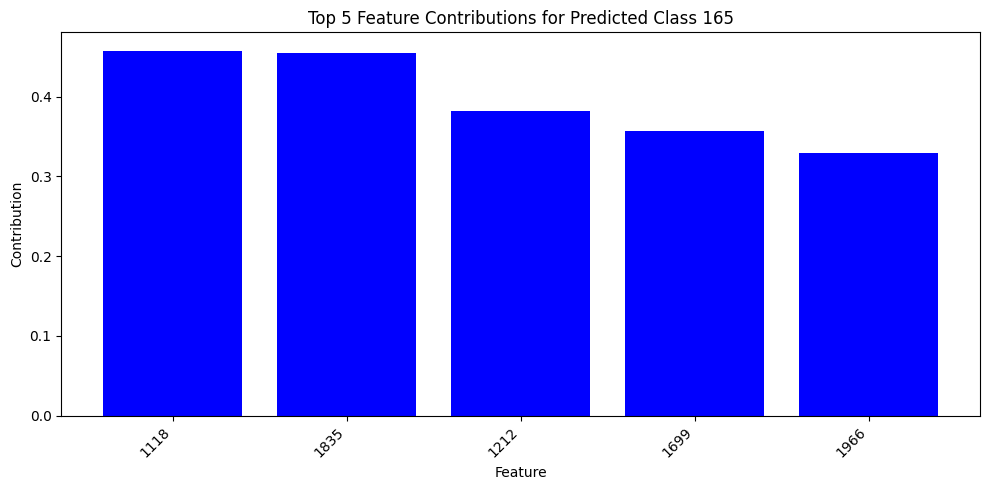

True Class: Shiny_Cowbird
Predicted Class: Shiny_Cowbird


In [8]:
id_image = 1680

concept_ids, concept_weights = cbm.plot_instance_feature_importance(id_image)

1532


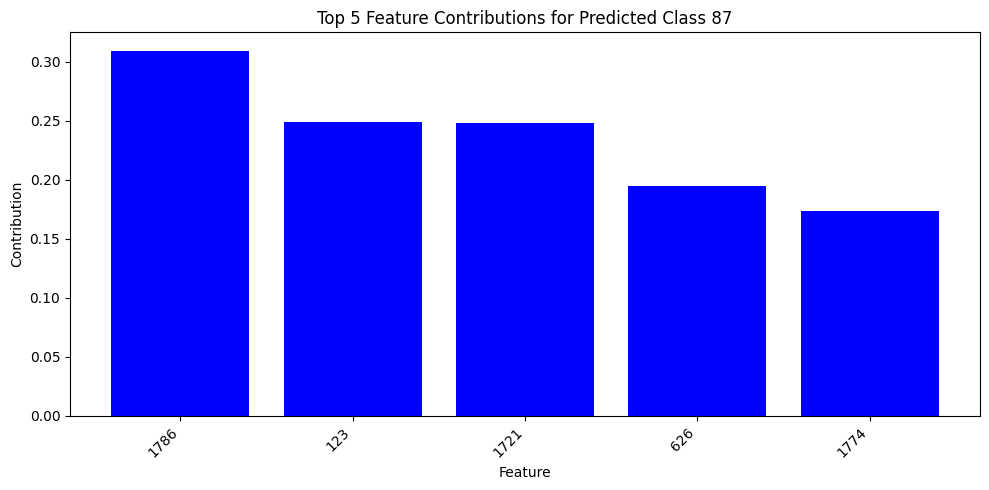

True Class: Herring_Gull
Predicted Class: Herring_Gull
../Datasets/CUB_200_2011/images/062.Herring_Gull/Herring_Gull_0049_46508.jpg Herring_Gull_0049_46508.jpg
['../Segments/CUB_200_2011_SAM2/crops/109.American_Redstart/American_Redstart_0128_102983_OUT_CROP_55_X_.jpg', '../Segments/CUB_200_2011_SAM2/crops/061.Heermann_Gull/Heermann_Gull_0043_45939_OUT_CROP_1_X_.jpg', '../Segments/CUB_200_2011_SAM2/crops/124.Le_Conte_Sparrow/Le_Conte_Sparrow_0020_117035_OUT_CROP_10_X_.jpg', '../Segments/CUB_200_2011_SAM2/crops/003.Sooty_Albatross/Sooty_Albatross_0073_1171_OUT_CROP_1_X_.jpg', '../Segments/CUB_200_2011_SAM2/crops/057.Rose_breasted_Grosbeak/Rose_Breasted_Grosbeak_0024_39398_OUT_CROP_12_X_.jpg']
../Segments/CUB_200_2011_SAM2/crops/109.American_Redstart/American_Redstart_0128_102983_OUT_CROP_55_X_.jpg
../Segments/CUB_200_2011_SAM2/crops/061.Heermann_Gull/Heermann_Gull_0043_45939_OUT_CROP_1_X_.jpg
../Segments/CUB_200_2011_SAM2/crops/124.Le_Conte_Sparrow/Le_Conte_Sparrow_0020_117035_OUT_CROP_

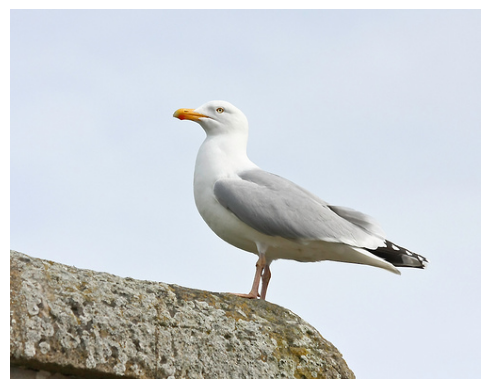

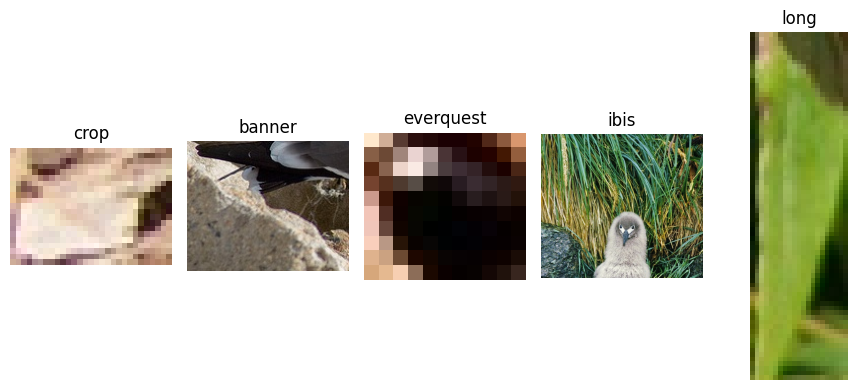

In [9]:

def display_images_with_main(image_paths, main_image_path, concept_names, num_secondary=5):
    """
    Display a main image prominently and a series of smaller images in a row layout.

    Parameters:
    - image_paths (list): List of file paths for the secondary images.
    - main_image_path (str): File path of the main image to be displayed larger.
    - num_secondary (int): Number of secondary images to display. Default is 5.
    """
    # Remove duplicates from image paths
    image_paths = image_paths[:num_secondary]
    print(image_paths)
    # Display the main image
    main_img = Image.open(main_image_path)
    plt.imshow(main_img)
    plt.axis("off")

    # Set up the grid: main image in a larger size, followed by smaller images
    fig, axes = plt.subplots(1, num_secondary, figsize=(9, 4))

    # Display each of the secondary images
    for i, image_path in enumerate(image_paths):
        print(image_path)
        img = cv2.imread(image_path)
        try:
            axes[i].imshow(img)
        except:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(concept_names[i])

    plt.tight_layout()
    plt.show()


def display_concepts(id_image, cbm, raw_path, raw_path_dataset):

    def extract_until_number(strings):
        return [process_string(s) for s in strings]

    def process_string(s):
        match = re.match(r"^([^0-9]+)", s)
        return match.group(1).strip("_") if match else s

    concept_ids, concept_weights = cbm.plot_instance_feature_importance(id_image)

    # Get the main image path

    folder_names = os.listdir(raw_path_dataset)
    image_name = list(cbm.data_test_raw.keys())[id_image]
    folder_name = process_string(image_name)
    for i in range(len(folder_names)):
        if folder_name.lower() in folder_names[i].lower():
            folder_name = folder_names[i]
            break
    image_path_org = os.path.join(raw_path_dataset, folder_name, image_name)
    print(image_path_org, image_name)
    # Find paths to median images based on feature importance (as in your example)
    image_median_paths = []
    concept_names = []
    for idx in concept_ids[:5]:
        idx = int(idx)
        clustered_concepts = cbm.clustered_concepts_all
        data = clustered_concepts[idx]
        median_values = np.median(data, axis=0)
        distances = np.sum(np.abs(data - median_values), axis=1)
        median_index = np.argmin(distances)
        clustered_images = cbm.image_segments_names
        median_index = np.argsort(distances)

        # Select up to n images closest to median
        n = 20
        median_entries = [clustered_images[idx][i] for i in median_index[:n]]
        concept_emb = data[median_index[0]]
        concept_emb = torch.tensor(concept_emb).to(device)
        if text_features != None:
            sim = torch.nn.functional.cosine_similarity(concept_emb.to("cpu"), text_features.to("cpu")).cpu().float()

            top_index = sim.argsort(descending=True)
            #print(names[top_index[0]], median_index[0])
            concept_names.append(names[top_index[0]])
        else:
            concept_names.append("Concept " + str(idx))
        
        # Process and add paths for the secondary images
        def construct_path(strings):
            correct_strings = []
            for substring in strings:
                folder_name = process_string(substring)
                for i in range(len(folder_names)):
                    if folder_name.lower() in folder_names[i].lower():
                        folder_name = folder_names[i]
                        break                
                #substring = '_'.join(substring.split('_')[:-1]) + '_X_.jpg'
                #print(substring)
                
                substring = os.path.join(raw_path, folder_name, substring)
                correct_strings.append(substring)
            return correct_strings

        image_median_paths.append(construct_path(median_entries)[0])
        # print(image_median_paths)

    # Call the function to display images
    display_images_with_main(image_median_paths, image_path_org, concept_names)


# Example usage:
id_image = random.randint(0, len(cbm.data_test_raw))
id_image = 1532
print(id_image)
display_concepts(id_image, cbm, raw_path, raw_path_dataset)

In [ ]:
img = cv2.imread("../Segments/CUB_200_2011_SAM2/crops/167.Hooded_Warbler/Hooded_Warbler_0078_165123_OUT_CROP_1_wing.jpg")

In [ ]:
def display_images_with_main(image_paths, main_image_path, concept_names, num_secondary=5):
    """
    Display a main image prominently and a series of smaller images in a row layout.

    Parameters:
    - image_paths (list): List of file paths for the secondary images.
    - main_image_path (str): File path of the main image to be displayed larger.
    - num_secondary (int): Number of secondary images to display. Default is 5.
    """
    # Remove duplicates from image paths
    image_paths = image_paths[:num_secondary]
    print(image_paths)
    # Display the main image
    main_img = Image.open(main_image_path)
    plt.imshow(main_img)
    plt.axis("off")

    # Set up the grid: main image in a larger size, followed by smaller images
    fig, axes = plt.subplots(1, num_secondary, figsize=(9, 4))

    # Display each of the secondary images
    for i, image_path in enumerate(image_paths):
        print(image_path)
        img = cv2.imread(image_path)
        try:
            axes[i].imshow(img)
        except:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(concept_names[i])

    plt.tight_layout()
    plt.show()


def display_concepts(id_image, cbm, raw_path, raw_path_dataset):

    def extract_until_number(strings):
        return [process_string(s) for s in strings]

    def process_string(s):
        match = re.match(r"^([^0-9]+)", s)
        return match.group(1).strip("_") if match else s

    concept_ids, concept_weights = cbm.plot_instance_feature_importance(id_image)

    # Get the main image path

    folder_names = os.listdir(raw_path_dataset)
    image_name = list(cbm.data_test_raw.keys())[id_image]
    folder_name = process_string(image_name)
    for i in range(len(folder_names)):
        if folder_name.lower() in folder_names[i].lower():
            folder_name = folder_names[i]
            break
    image_path_org = os.path.join(raw_path_dataset, folder_name, image_name)
    print(image_path_org, image_name)
    # Find paths to median images based on feature importance (as in your example)
    image_median_paths = []
    concept_names = []
    for idx in concept_ids[:5]:
        idx = int(idx)
        clustered_concepts = cbm.clustered_concepts_all
        data = clustered_concepts[idx]
        median_values = np.median(data, axis=0)
        distances = np.sum(np.abs(data - median_values), axis=1)
        median_index = np.argmin(distances)
        clustered_images = cbm.image_segments_names
        median_index = np.argsort(distances)

        # Select up to n images closest to median
        n = 20
        median_entries = [clustered_images[idx][i] for i in median_index[:n]]

        concept_emb = data[median_index[0]]
        concept_emb = torch.tensor(concept_emb).to(device)
        if text_features != None:
            sim = torch.nn.functional.cosine_similarity(concept_emb, text_features).cpu().float()

            top_index = sim.argsort(descending=True)
            print(names[top_index[0]], median_index[0])
            concept_names.append(names[top_index[0]])
        else:
            concept_names.append("Concept " + str(idx))
        
        # Process and add paths for the secondary images
        def construct_path(strings):
            correct_strings = []
            for substring in strings:
                folder_name = process_string(substring)
                for i in range(len(folder_names)):
                    if folder_name.lower() in folder_names[i].lower():
                        folder_name = folder_names[i]
                        break
                substring = os.path.join(raw_path, folder_name, substring)
                correct_strings.append(substring)
            return correct_strings

        image_median_paths.append(construct_path(median_entries)[0])
        # print(image_median_paths)

    # Call the function to display images
    display_images_with_main(image_median_paths, image_path_org, concept_names)


# Example usage:
#id_image = random.randint(0, len(cbm.data_test_raw))
print(id_image)
display_concepts(id_image, cbm, raw_path, raw_path_dataset)

In [ ]:
def display_concepts_(id_image, cbm, raw_path, raw_path_dataset):

    def extract_until_number(strings):
        return [process_string(s) for s in strings]

    def process_string(s):
        match = re.match(r"^([^0-9]+)", s)
        return match.group(1).strip("_") if match else s

    concept_ids, concept_weights = plot_instance_feature_importance_(cbm, id_image)

    # Get the main image path

    folder_names = os.listdir(raw_path_dataset)
    image_name = list(cbm.data_test_raw.keys())[id_image]
    folder_name = process_string(image_name)
    for i in range(len(folder_names)):
        if folder_name.lower() in folder_names[i].lower():
            folder_name = folder_names[i]
            break
    image_path_org = os.path.join(raw_path_dataset, folder_name, image_name)
    # Find paths to median images based on feature importance (as in your example)
    image_median_paths = []
    for idx in concept_ids[:5]:
        idx = int(idx)
        clustered_concepts = cbm.clustered_concepts_all
        data = clustered_concepts[idx]
        median_values = np.median(data, axis=0)
        distances = np.sum(np.abs(data - median_values), axis=1)
        median_index = np.argmin(distances)
        clustered_images = cbm.image_segments_names
        median_index = np.argsort(distances)

        # Select up to n images closest to median
        n = 20
        median_entries = [clustered_images[idx][i] for i in median_index[:n]]

        # Process and add paths for the secondary images
        def construct_path(strings):
            correct_strings = []
            for substring in strings:
                folder_name = process_string(substring)
                for i in range(len(folder_names)):
                    if folder_name.lower() in folder_names[i].lower():
                        folder_name = folder_names[i]
                        break
                substring = os.path.join(raw_path, folder_name, substring)
                correct_strings.append(substring)
            return correct_strings

        image_median_paths.append(construct_path(median_entries)[0])
        # print(image_median_paths)

    # Call the function to display images
    return image_median_paths, image_path_org


def plot_instance_feature_importance_(self, index, n=10, save=False):
    """
    Plot the top n features contributing to the model's prediction for a given instance.

    Args:
        instance: A single instance (feature vector) as a numpy array or torch tensor.
        n: Number of top features to plot.
    """
    # Ensure the model is trained
    if not hasattr(self, "model"):
        raise ValueError(
            "Model not trained yet. Please train the model before plotting feature importance."
        )

    instance = self.X_test[index : index + 1]
    # Convert instance to tensor if it's a numpy array
    if isinstance(instance, np.ndarray):
        instance = torch.tensor(instance, dtype=torch.float32)

    # Move instance to appropriate device
    device = next(self.model.parameters()).device
    instance = instance.to(device)

    # Add batch dimension if necessary
    if instance.dim() == 1:
        instance = instance.unsqueeze(0)

    # Get the weights and biases from the trained model
    weights = (
        self.model.linear.weight.detach().cpu().numpy()
    )  # Shape: (num_classes, num_features)
    biases = self.model.linear.bias.detach().cpu().numpy()  # Shape: (num_classes,)

    # Get the feature values
    feature_values = instance.detach().cpu().numpy().squeeze()  # Shape: (num_features,)

    # Compute the contribution of each feature to each class
    # For linear models: contribution = weight * feature_value
    contributions = weights * feature_values  # Shape: (num_classes, num_features)

    # Get the predicted class
    with torch.no_grad():
        outputs = self.model(instance)
        probabilities = torch.softmax(outputs, dim=1).squeeze()
        predicted_class = torch.argmax(probabilities).item()

    # Get the contributions for the predicted class
    class_contributions = contributions[predicted_class]

    # Sort the features by absolute contribution
    sorted_indices = np.argsort(np.abs(class_contributions))[::-1]
    top_indices = sorted_indices[:n]
    top_contributions = class_contributions[top_indices]

    # Get feature names if available
    if hasattr(self, "feature_names"):
        top_features = [self.feature_names[i] for i in top_indices]
    else:
        top_features = [str(i) for i in top_indices]

    if save:
        plt.savefig(f"./imgs/feature_importance_{index}.pdf")
    return top_features, top_contributions


prompt = concept_name
emb = model_name
seg_model = segmentation_technique
res = {}
for id_image in tqdm(range(len(cbm.data_test_raw))):
    concept_ids, concept_weights = plot_instance_feature_importance_(cbm, id_image)
    # Call the function to display images
    image_median_paths, image_path_org = display_concepts_(
        id_image, cbm, raw_path, raw_path_dataset
    )
    # display_images_with_main(image_median_paths, image_path_org, mask, dataset, seg_model, concept_name)
    res[image_path_org] = image_median_paths

if not os.path.exists(f"/ceph/pknab/pknab/03_CLIP/SegCBM/CBM/clusters_2/{dataset}"):
    os.makedirs(f"/ceph/pknab/pknab/03_CLIP/SegCBM/CBM/clusters_2/{dataset}")
torch.save(
    res,
    f"/ceph/pknab/pknab/03_CLIP/SegCBM/CBM/clusters_2/{dataset}/top5concepts_{dataset}_{seg_model}_{prompt}_{emb}.torch",
)

In [ ]:
# Display the images of the median instances of the clusters
start_index = 700

for i in range(60):

    idx = start_index + i

    clustered_concepts = cbm.clustered_concepts_all

    data = clustered_concepts[idx]
    median_values = np.median(data, axis=0)
    distances = np.sum(np.abs(data - median_values), axis=1)

    # Find the index of the row with the smallest distance
    median_row_index = np.argmin(distances)
    if (clustered_concepts[idx][median_row_index] != cbm.clustered_concepts[idx]).all():
        print(clustered_concepts[idx][median_row_index])
        print(cbm.clustered_concepts[idx])

    median_index = median_row_index
    clustered_images = cbm.image_segments_names

    # get all indices of the median index
    median_index = np.argsort(distances)

    n = 20

    median_entries = [clustered_images[idx][i] for i in median_index[:n]]

    def extract_until_number(strings):
        def process_string(s):
            match = re.match(r"^([^0-9]+)", s)
            return match.group(1).strip("_") if match else s

        return [process_string(s) for s in strings]

    folder_paths = os.listdir(raw_path)
    result = extract_until_number(median_entries)

    image_paths = []

    for i, name in enumerate(result):
        for j in folder_paths:
            if name in j:
                image_paths.append(raw_path + "/" + j + "/" + median_entries[i])
                # print(image_paths)

    # drop duplicates:
    image_paths = list(dict.fromkeys(image_paths))
    print(image_paths)
    # switch image path 0 with 4
    if len(image_paths) > 9:
        image_paths[0], image_paths[4] = image_paths[4], image_paths[0]

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    for i, image_path in enumerate(image_paths[:9]):
        # Open and display the image
        img = cv2.imread(image_path)
        row = i // 3
        col = i % 3
        # Image data of dtype object cannot be converted to float
        try:
            axes[row, col].imshow(img)
        except:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[row, col].imshow(img)

        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
cluster_lengths_with_ids = [
    [c, len(cbm.clustered_concepts_all[c])] for c in cbm.clustered_concepts_all.keys()
]
cluster_lengths = [
    len(cbm.clustered_concepts_all[c]) for c in cbm.clustered_concepts_all.keys()
]

cluster_lengths.sort()
# plot histogram
plt.hist(cluster_lengths, bins=range(1, max(cluster_lengths) + 1))
plt.show()